### 1. Imports and Node Definition

This section imports necessary libraries and defines a `Node` namedtuple, which will be used to represent states in the search algorithms.

In [1]:
from collections import deque, namedtuple # deque for BFS, namedtuple for Node structure
import heapq # For priority queue in UCS, Greedy, A*
import time # To measure execution time of algorithms
from itertools import permutations # For heuristic calculation (exact assignment)
import matplotlib.pyplot as plt # For plotting results
import math # For math.nan in plot data

# Define a Node structure for the search algorithms.
# state: (player_pos, frozenset(box_positions))
# parent: reference to the parent Node
# action: action taken to reach this state from parent
# cost: cumulative cost to reach this state
# depth: depth of the node in the search tree
Node = namedtuple("Node", ["state", "parent", "action", "cost", "depth"])

### 2. Parser / Grid Utilities

These functions handle parsing the ASCII level representation into internal data structures (grid, player, boxes, goals) and printing the grid back for visualization.

In [2]:
def parse_level(lines):
    """Parse ASCII level into grid, player, boxes, goals."""
    # Create a mutable list of lists to represent the grid
    grid = [list(line.rstrip("\n")) for line in lines]
    rows = len(grid)
    cols = max(len(row) for row in grid) if grid else 0 # Handle empty grid case

    # Ensure all rows have the same length by padding with spaces
    for row in grid:
        if len(row) < cols:
            row.extend(' ' * (cols - len(row)))

    # Initialize player, boxes, and goals
    player = None
    boxes = set()
    goals = set()

    # Iterate through the grid to identify elements
    for r in range(rows):
        for c in range(cols):
            pos = (r, c)
            ch = grid[r][c]
            if ch == '@': # Player
                player = pos
                grid[r][c] = ' ' # Replace player symbol with floor on the grid
            elif ch == '+': # Player on a goal
                player = pos
                goals.add(pos)
                grid[r][c] = '.' # Replace player-on-goal symbol with goal on the grid
            elif ch == '$': # Box
                boxes.add(pos)
                grid[r][c] = ' ' # Replace box symbol with floor on the grid
            elif ch == '*': # Box on a goal
                boxes.add(pos)
                goals.add(pos)
                grid[r][c] = '.' # Replace box-on-goal symbol with goal on the grid
            elif ch == '.': # Goal
                goals.add(pos)
            # '#' (wall) and ' ' (floor) remain as they are in the grid

    # Return the grid, player position, and frozensets of boxes and goals
    # frozenset is used for immutability, essential for state hashing in search
    return grid, player, frozenset(boxes), frozenset(goals)

def print_grid(grid, player, boxes, goals):
    """Prints the current state of the Sokoban level to the console."""
    rows = len(grid)
    cols = len(grid[0])
    out = [] # List to store lines of the output grid

    for r in range(rows):
        line = [] # List to build each row's characters
        for c in range(cols):
            pos = (r, c)
            if pos == player: # Check if current position is the player
                line.append('+' if pos in goals else '@') # '+' if on goal, '@' otherwise
            elif pos in boxes: # Check if current position is a box
                line.append('*' if pos in goals else '$') # '*' if on goal, '$' otherwise
            else: # Otherwise, it's a floor, wall, or goal
                if pos in goals: # Check if current position is a goal
                    line.append('.')
                else: # Must be a wall or empty floor
                    ch = grid[r][c]
                    line.append('#' if ch == '#' else ' ') # '#' if wall, ' ' if floor
        out.append(''.join(line)) # Join characters to form a row string
    print("\n".join(out)) # Join rows with newlines and print
    print() # Add an extra newline for spacing

### 3. Game Mechanics (Push-only)

This section defines the rules of movement for the player and boxes, including how successors states are generated and basic deadlock detection for pruning impossible paths.

In [3]:
# DIRS: Dictionary mapping direction names to their (dr, dc) coordinate changes
DIRS = {'Up':(-1,0), 'Down':(1,0), 'Left':(0,-1), 'Right':(0,1)}

def in_bounds(grid, pos):
    """Checks if a given position (r,c) is within the grid boundaries."""
    r,c = pos
    # Check if row and column are within the valid range of the grid
    return 0 <= r < len(grid) and 0 <= c < len(grid[0])

def is_free_cell(grid, pos, boxes):
    """Checks if a cell is free (not a wall and not occupied by a box)."""
    if not in_bounds(grid, pos): # Out of bounds is not free
        return False
    if grid[pos[0]][pos[1]] == '#': # Wall is not free
        return False
    if pos in boxes: # Cell occupied by a box is not free
        return False
    return True

def reachable_tiles(grid, player, boxes):
    """
    Performs a Breadth-First Search (BFS) to find all tiles the player can reach.
    Boxes are treated as obstacles that the player cannot move through.
    """
    q = deque([player]) # Initialize queue with player's current position
    seen = {player} # Set to keep track of visited tiles
    while q:
        p = q.popleft() # Get the current position from the front of the queue
        for d in DIRS.values(): # Explore all four directions
            np = (p[0]+d[0], p[1]+d[1]) # Calculate new position
            if np in seen: continue # Skip if already visited
            if not in_bounds(grid, np): continue # Skip if out of bounds
            if grid[np[0]][np[1]] == '#': continue # Skip if it's a wall
            if np in boxes: continue # Skip if it's a box (player cannot move through boxes)
            seen.add(np) # Mark as visited
            q.append(np) # Add to queue for further exploration
    return seen # Return the set of all reachable tiles

# --- Deadlock detection helpers ---

def is_corner_deadlock(pos, grid):
    """Return True if pos is a corner (two orthogonal walls)."""
    r,c = pos

    # Check for walls in adjacent cells in all four directions
    # Boundary conditions are treated as walls.
    up = (not in_bounds(grid, (r-1,c))) or grid[r-1][c] == '#'
    down = (not in_bounds(grid, (r+1,c))) or grid[r+1][c] == '#'
    left = (not in_bounds(grid, (r,c-1))) or grid[r][c-1] == '#'
    right = (not in_bounds(grid, (r,c+1))) or grid[r][c+1] == '#'

    # A corner is formed if there's a wall vertically AND horizontally.
    # For example, (up and left) or (up and right) etc.
    if (up or down) and (left or right):
        return True
    return False

def forms_2x2_block(boxes, pos):
    """Check if pos is part of a 2x2 block of boxes (simple freeze)."""
    r,c = pos
    # A 2x2 block can have `pos` as its top-left, top-right, bottom-left, or bottom-right corner.
    # We check all four possible origins of a 2x2 block that would include 'pos'.
    origins = [(r, c), (r-1, c), (r, c-1), (r-1, c-1)]
    for orr, oc in origins:
        # Define the four cells that would form a 2x2 block starting at (orr, oc)
        cells = [(orr, oc), (orr+1, oc), (orr, oc+1), (orr+1, oc+1)]
        # If all four cells are occupied by boxes, a 2x2 block is formed
        if all(cell in boxes for cell in cells):
            return True
    return False

def is_deadlock_state(boxes, grid, goals):
    """
    Simple deadlock detection rules:
    1. A box not on a goal in a corner (two adjacent walls).
    2. A box is part of a 2x2 block of boxes, and none of those 4 cells are goals.
    This is a conservative check to prune impossible states early.
    """
    bset = set(boxes) # Convert frozenset to set for faster lookups
    for b in boxes:
        if b in goals: # Boxes already on a goal don't cause deadlocks on their own
            continue

        # --- Corner Deadlock Check ---
        r,c = b
        # Determine if there are walls/boundaries blocking movement
        up = (not in_bounds(grid, (r-1,c))) or grid[r-1][c] == '#'
        down = (not in_bounds(grid, (r+1,c))) or grid[r+1][c] == '#'
        left = (not in_bounds(grid, (r,c-1))) or grid[r][c-1] == '#'
        right = (not in_bounds(grid, (r,c+1))) or grid[r][c+1] == '#'

        # If the box is trapped in a corner (e.g., wall above and wall to the left)
        if (up or down) and (left or right): # Check for orthogonal walls/boundaries
            # More precise check: ensure actual walls are present in both directions to form a corner
            # Also, allow if an orthogonal neighbor cell is a goal (can push box onto it)
            orth_neighbors = [] # List to store orthogonal neighbor cells
            if in_bounds(grid, (r-1,c)): orth_neighbors.append((r-1,c))
            if in_bounds(grid, (r+1,c)): orth_neighbors.append((r+1,c))
            if in_bounds(grid, (r,c-1)): orth_neighbors.append((r,c-1))
            if in_bounds(grid, (r,c+1)): orth_neighbors.append((r,c+1))

            # If no orthogonal neighbor is a goal, then this corner is a deadlock
            if not any(n in goals for n in orth_neighbors):
                # If the box is not on a goal and is in a corner with no escape via goal cells
                return True

        # --- 2x2 Block Deadlock Check ---
        if forms_2x2_block(bset, b): # Check if the box 'b' is part of a 2x2 box block
            # Need to iterate through all possible 2x2 block origins that contain 'b'
            # and check if *any* cell in that specific 2x2 block is a goal.
            r_b, c_b = b # Box position

            # Four possible top-left corners of a 2x2 block that contain (r_b, c_b)
            possible_origins = [
                (r_b, c_b),       # (r_b, c_b) is top-left
                (r_b - 1, c_b),   # (r_b, c_b) is bottom-left
                (r_b, c_b - 1),   # (r_b, c_b) is top-right
                (r_b - 1, c_b - 1) # (r_b, c_b) is bottom-right
            ]

            for orr, oc in possible_origins:
                # Define the four cells for the current 2x2 block candidate
                cells_in_block = [
                    (orr, oc), (orr + 1, oc),
                    (orr, oc + 1), (orr + 1, oc + 1)
                ]

                # Check if all cells in this candidate block are actual boxes
                if all(cell in bset for cell in cells_in_block):
                    # If a 2x2 block of boxes is found, check if any cell in it is a goal
                    if not any(cell in goals for cell in cells_in_block):
                        return True # Deadlock if no goal in the 2x2 block
    return False # No deadlock detected

def push_successors(grid, state, goals):
    """
    Generates all possible next states by pushing a single box.
    - Determines player's reachable positions.
    - For each box, checks if the player can get 'behind' it and push it to a 'free' spot.
    - Filters out deadlock states.
    """
    player, boxes = state # Unpack current state: player position and frozenset of boxes
    boxes_set = set(boxes) # Convert frozenset to set for efficient `in` checks

    # Find all tiles the player can reach without moving boxes
    reachable = reachable_tiles(grid, player, boxes_set)
    succs = [] # List to store successor states

    for box in boxes: # Iterate through each box in the current state
        br, bc = box # Box's row and column
        for dir_name, d in DIRS.items(): # Try pushing the box in each direction
            # 'behind' is the cell where the player must stand to push the box
            behind = (br - d[0], bc - d[1])
            # 'ahead' is the cell where the box will move into
            ahead = (br + d[0], bc + d[1])

            # --- Check for legality of the push ---
            # 1. Player must be able to reach the 'behind' cell
            if behind not in reachable: continue
            # 2. 'ahead' cell must be within grid bounds
            if not in_bounds(grid, ahead): continue
            # 3. 'ahead' cell must not be a wall
            if grid[ahead[0]][ahead[1]] == '#': continue
            # 4. 'ahead' cell must not already contain another box
            if ahead in boxes_set: continue

            # If all conditions met, this is a legal push
            # Generate the new box configuration
            new_boxes = set(boxes_set) # Start with current boxes
            new_boxes.remove(box) # Remove the box from its old position
            new_boxes.add(ahead) # Add the box to its new position

            # The player ends up at the box's original position after pushing it
            new_player = box
            new_state = (new_player, frozenset(new_boxes)) # Create the new state

            # --- Deadlock filter ---
            # If the new state leads to an immediate deadlock, prune this path
            if is_deadlock_state(new_state[1], grid, goals):
                continue

            # Define the action taken
            action = f"Push {box} {dir_name}"
            # Add the successor to the list with a cost of 1 (one push)
            succs.append((action, new_state, 1))

    return succs # Return all valid successor states

def is_goal_state(state, goals):
    """Checks if the current state is a goal state (all boxes are on goals)."""
    # A goal state is reached when the set of all box positions is identical to the set of all goal positions.
    # This implies that every goal has a box and every box is on a goal.
    return set(state[1]) == set(goals) # Compare the set of box positions with the set of goal positions

### 4. Heuristic (Matching)

This section provides an admissible heuristic function that estimates the minimum number of pushes required to reach a goal state. It uses Manhattan distance with an optimal assignment for small numbers of boxes.

In [4]:
def manhattan(a,b):
    """Calculates the Manhattan distance between two points (a,b)."""
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

def heuristic_sum_min_assignment(boxes, goals):
    """
    Admissible heuristic: minimal sum of Manhattan distances between boxes and goals.
    For small box counts (<=7), it uses exact assignment via permutations for optimality.
    For larger counts, it uses a greedy nearest-goal assignment.
    """
    boxes = list(boxes) # Convert frozenset to list for indexing
    goals = list(goals) # Convert frozenset to list for indexing
    b = len(boxes) # Number of boxes
    g = len(goals) # Number of goals

    if b == 0: return 0 # If no boxes, cost is 0
    if b > g: return float('inf') # More boxes than goals means unsolvable (infinite cost)

    if b <= 7: # For a small number of boxes, compute exact minimum assignment using permutations
        best = float('inf') # Initialize best sum to infinity
        # Iterate through all permutations of 'b' goals chosen from 'g' goals
        for perm in permutations(range(g), b):
            s = 0 # Current sum of Manhattan distances for this permutation
            for i, gi in enumerate(perm):
                s += manhattan(boxes[i], goals[gi]) # Add distance for box i to goal gi
                if s >= best: # Optimization: if current sum already exceeds best, no need to continue
                    break
            if s < best: # Update best if a smaller sum is found
                best = s
        return best
    else: # For larger box counts, use a greedy approach (less accurate but faster)
        remaining_goals = set(goals) # Keep track of goals not yet assigned
        total_heuristic_cost = 0
        for bx in boxes:
            # Find the closest unassigned goal for the current box
            nearest_goal = min(remaining_goals, key=lambda gpos: manhattan(bx, gpos))
            total_heuristic_cost += manhattan(bx, nearest_goal) # Add its distance
            remaining_goals.remove(nearest_goal) # Mark goal as assigned
            if not remaining_goals: # If all goals are assigned, break
                break
        return total_heuristic_cost

### 5. Reconstruct Path

This utility function reconstructs the sequence of actions and states from a goal node back to the start node.

In [5]:
def reconstruct_path(node):
    """Reconstructs the path (actions and states) from a goal node back to the start."""
    actions = [] # List to store actions in reverse order
    states = [] # List to store states in reverse order
    current_node = node
    while current_node.parent is not None: # Traverse up until the start node (which has no parent)
        actions.append(current_node.action)
        states.append(current_node.state)
        current_node = current_node.parent # Move to the parent node
    actions.reverse() # Reverse to get actions from start to goal
    states.reverse() # Reverse to get states from start to goal
    return actions, states

### 6. Search Algorithms (Push-space)

This section implements various search algorithms (BFS, UCS, Greedy Best-First, A
*) tailored for the Sokoban push-only problem. Each algorithm explores the state space to find a solution.

In [6]:
def bfs_push(grid, start_state, goals, max_nodes=200000):
    """Breadth-First Search (BFS) algorithm to find the shortest path in terms of pushes."""
    t0 = time.time() # Start time tracking
    frontier = deque([Node(start_state, None, None, 0, 0)]) # Initialize frontier (queue) with start node
    visited = {start_state} # Set to store visited states to avoid cycles
    nodes_expanded = 0
    max_frontier = 1 # Track maximum size of the frontier

    while frontier:
        node = frontier.popleft() # Dequeue the next node
        nodes_expanded += 1 # Increment expanded nodes count

        if is_goal_state(node.state, goals): # Check if current node is the goal
            actions, states = reconstruct_path(node) # Reconstruct path if goal found
            return {'found': True, 'cost': node.cost, 'time': time.time() - t0,
                    'nodes': nodes_expanded, 'max_frontier': max_frontier, 'visited': len(visited),
                    'actions': actions} # Return results

        # Generate successors for the current node
        for action, succ_state, c in push_successors(grid, node.state, goals):
            if succ_state not in visited: # If successor not visited
                visited.add(succ_state) # Mark as visited
                # Create child node
                child = Node(succ_state, node, action, node.cost + c, node.depth + 1)
                frontier.append(child) # Enqueue child node

        max_frontier = max(max_frontier, len(frontier)) # Update max frontier size

        if nodes_expanded > max_nodes: # Stop if max_nodes limit is reached
            print(f"BFS: Max nodes expanded ({max_nodes}) reached.")
            break

    return {'found': False, 'cost': None, 'time': time.time() - t0,
            'nodes': nodes_expanded, 'max_frontier': max_frontier, 'visited': len(visited),
            'actions': None} # Return failure if no solution found

def ucs_push(grid, start_state, goals, max_nodes=500000):
    """Uniform Cost Search (UCS) algorithm, finds the path with the lowest cumulative cost (pushes)."""
    t0 = time.time() # Start time tracking
    frontier = [] # Initialize frontier as a min-heap (priority queue)
    counter = 0 # Used to break ties in heapq (insertion order)

    # Push start node: (cost, counter, Node)
    heapq.heappush(frontier, (0, counter, Node(start_state, None, None, 0, 0)))
    best_cost = {start_state: 0} # Dictionary to store the best known cost to reach each state
    nodes_expanded = 0
    max_frontier = 1 # Track maximum size of the frontier

    while frontier:
        cost, _, node = heapq.heappop(frontier) # Pop node with the lowest cost
        nodes_expanded += 1

        # If we found a cheaper path to this node already, skip it
        if cost > best_cost.get(node.state, float('inf')):
            continue

        if is_goal_state(node.state, goals): # Check if current node is the goal
            actions, states = reconstruct_path(node)
            return {'found': True, 'cost': node.cost, 'time': time.time() - t0,
                    'nodes': nodes_expanded, 'max_frontier': max_frontier, 'visited': len(best_cost),
                    'actions': actions}

        # Generate successors
        for action, succ_state, c in push_successors(grid, node.state, goals):
            new_cost = node.cost + c # Calculate cost to reach successor
            # If this new path is cheaper than any previously found path to succ_state
            if new_cost < best_cost.get(succ_state, float('inf')):
                best_cost[succ_state] = new_cost # Update best cost
                counter += 1 # Increment tie-breaker counter
                # Create child node and push to frontier with its (new_cost, counter, child_node)
                child = Node(succ_state, node, action, new_cost, node.depth + 1)
                heapq.heappush(frontier, (new_cost, counter, child))

        max_frontier = max(max_frontier, len(frontier))

        if nodes_expanded > max_nodes:
            print(f"UCS: Max nodes expanded ({max_nodes}) reached.")
            break

    return {'found': False, 'cost': None, 'time': time.time() - t0,
            'nodes': nodes_expanded, 'max_frontier': max_frontier, 'visited': len(best_cost),
            'actions': None}

def greedy_push(grid, start_state, goals, max_nodes=200000):
    """Greedy Best-First Search algorithm, prioritizes nodes with the lowest heuristic value."""
    t0 = time.time()
    frontier = [] # Min-heap based priority queue
    counter = 0

    # Calculate initial heuristic for the start state
    h0 = heuristic_sum_min_assignment(start_state[1], goals)
    # Push start node: (heuristic_value, counter, Node)
    heapq.heappush(frontier, (h0, counter, Node(start_state, None, None, 0, 0)))
    visited = {start_state} # Set to store visited states to avoid re-exploring same state
    nodes_expanded = 0
    max_frontier = 1

    while frontier:
        _, _, node = heapq.heappop(frontier) # Pop node with the lowest heuristic value (cost is ignored for priority)
        nodes_expanded += 1

        if is_goal_state(node.state, goals):
            actions, states = reconstruct_path(node)
            return {'found': True, 'cost': node.cost, 'time': time.time() - t0,
                    'nodes': nodes_expanded, 'max_frontier': max_frontier, 'visited': len(visited),
                    'actions': actions}

        # Generate successors
        for action, succ_state, c in push_successors(grid, node.state, goals):
            if succ_state not in visited: # Only explore if not already visited
                visited.add(succ_state)
                h = heuristic_sum_min_assignment(succ_state[1], goals) # Calculate heuristic for successor
                counter += 1
                # Create child node and push to frontier with its (heuristic_value, counter, child_node)
                # The actual cost 'node.cost + c' is stored in the node but not used for priority here.
                child = Node(succ_state, node, action, node.cost + c, node.depth + 1)
                heapq.heappush(frontier, (h, counter, child))

        max_frontier = max(max_frontier, len(frontier))

        if nodes_expanded > max_nodes:
            print(f"Greedy: Max nodes expanded ({max_nodes}) reached.")
            break

    return {'found': False, 'cost': None, 'time': time.time() - t0,
            'nodes': nodes_expanded, 'max_frontier': max_frontier, 'visited': len(visited),
            'actions': None}

def astar_push(grid, start_state, goals, max_nodes=200000):
    """A* Search algorithm, combines path cost (g) and heuristic (h) for priority (f = g + h)."""
    t0 = time.time()
    frontier = [] # Min-heap based priority queue
    counter = 0

    # Calculate initial heuristic for the start state
    h0 = heuristic_sum_min_assignment(start_state[1], goals)
    # Push start node: (f_value = g+h, counter, Node)
    heapq.heappush(frontier, (h0, counter, Node(start_state, None, None, 0, 0)))
    best_cost = {start_state: 0} # Stores the g-value (cost from start) for each visited state
    nodes_expanded = 0
    max_frontier = 1

    while frontier:
        f, _, node = heapq.heappop(frontier) # Pop node with the lowest f-value
        nodes_expanded += 1

        # If we found a cheaper path (lower g-value) to this node already, skip it
        # This ensures we process the best path first for a given state
        if node.cost > best_cost.get(node.state, float('inf')):
            continue

        if is_goal_state(node.state, goals):
            actions, states = reconstruct_path(node)
            return {'found': True, 'cost': node.cost, 'time': time.time() - t0,
                    'nodes': nodes_expanded, 'max_frontier': max_frontier, 'visited': len(best_cost),
                    'actions': actions}

        # Generate successors
        for action, succ_state, c in push_successors(grid, node.state, goals):
            new_cost_g = node.cost + c # Calculate new g-value (cost from start)

            # If this new path has a lower g-value to succ_state than previously known
            if new_cost_g < best_cost.get(succ_state, float('inf')):
                best_cost[succ_state] = new_cost_g # Update best g-value for this state
                h = heuristic_sum_min_assignment(succ_state[1], goals) # Calculate heuristic for successor
                counter += 1
                # Create child node and push to frontier with its f-value (g + h)
                child = Node(succ_state, node, action, new_cost_g, node.depth + 1)
                heapq.heappush(frontier, (new_cost_g + h, counter, child))

        max_frontier = max(max_frontier, len(frontier))

        if nodes_expanded > max_nodes:
            print(f"A*: Max nodes expanded ({max_nodes}) reached.")
            break

    return {'found': False, 'cost': None, 'time': time.time() - t0,
            'nodes': nodes_expanded, 'max_frontier': max_frontier, 'visited': len(best_cost),
            'actions': None}

### 7. Runner and Plotting Utilities

This section contains the main function `run_all_and_plot` which orchestrates the execution of all search algorithms, collects their results, and visualizes the performance metrics using `matplotlib`.

In [7]:
def run_all_and_plot(grid, player, boxes, goals):
    """
    Executes all defined search algorithms on a given Sokoban level, collects performance metrics,
    and plots the results for comparison.
    """
    start_state = (player, boxes) # Define the initial state of the problem
    print("Initial level:")
    print_grid(grid, player, boxes, goals) # Display the initial level configuration

    # List of algorithms to run, each as (name, function_pointer)
    algs = [
        ('BFS', bfs_push),
        ('UCS', ucs_push),
        ('Greedy', greedy_push),
        ('A*', astar_push)
    ]
    results = {} # Dictionary to store results for each algorithm

    # Optionally run UCS first to get the optimal cost. This is useful for
    # judging the optimality of other algorithms (e.g., A* should also find optimal).
    print("Running UCS (reference optimal push-cost)...")
    ucs_res = ucs_push(grid, start_state, goals, max_nodes=500000) # Run UCS with a higher node limit
    print("  UCS:", ucs_res) # Print raw UCS result
    optimal_cost = ucs_res['cost'] if ucs_res['found'] else None # Store optimal cost if found

    # Run each algorithm and store its results
    for name, fn in algs:
        print(f"Running {name} ...")
        # Run algorithm with a common max_nodes limit for comparison
        res = fn(grid, start_state, goals, max_nodes=200000)

        # Determine if the found solution's cost matches the optimal cost (if UCS found one)
        res['optimal_compare_to_ucs'] = (res['cost'] == optimal_cost) if (res['found'] and optimal_cost is not None) else None
        results[name] = res # Store the results for the current algorithm

        # Print a summary of the algorithm's performance
        print(f"  -> {name} result: found={res['found']}, cost={res['cost']}, time={res['time']:.3f}s, nodes={res['nodes']}, max_front={res['max_frontier']}, visited≈{res['visited']}")

    # --- Prepare data for plotting ---
    names = list(results.keys()) # Algorithm names for x-axis labels
    times = [results[n]['time'] for n in names] # Execution times
    nodes = [results[n]['nodes'] for n in names] # Nodes expanded
    max_front = [results[n]['max_frontier'] for n in names] # Maximum frontier size
    # Solution costs (use math.nan if no solution was found for plotting)
    costs = [results[n]['cost'] if results[n]['cost'] is not None else math.nan for n in names]

    # --- Create 4-subplot bar chart for comparison ---
    fig, axs = plt.subplots(2, 2, figsize=(12, 8)) # 2x2 grid of subplots
    x = range(len(names)) # X-axis positions for bars

    # Plot 1: Time (s)
    axs[0,0].bar(x, times)
    axs[0,0].set_xticks(x); axs[0,0].set_xticklabels(names) # Set x-axis ticks and labels
    axs[0,0].set_ylabel('Time (s)'); axs[0,0].set_title('Algorithm comparison: Time (s)')

    # Plot 2: Nodes Expanded
    axs[0,1].bar(x, nodes)
    axs[0,1].set_xticks(x); axs[0,1].set_xticklabels(names)
    axs[0,1].set_ylabel('Nodes expanded'); axs[0,1].set_title('Nodes expanded')

    # Plot 3: Max Frontier Size
    axs[1,0].bar(x, max_front)
    axs[1,0].set_xticks(x); axs[1,0].set_xticklabels(names)
    axs[1,0].set_ylabel('Max frontier'); axs[1,0].set_title('Max frontier size')

    # Plot 4: Solution Cost (Pushes)
    # If cost is NaN (no solution), plot as 0 for visual representation
    cost_vals = [0 if math.isnan(c) else c for c in costs]
    axs[1,1].bar(x, cost_vals)
    axs[1,1].set_xticks(x); axs[1,1].set_xticklabels(names)
    axs[1,1].set_ylabel('Pushes (cost) [0 = no solution]'); axs[1,1].set_title('Solution cost (pushes)')

    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show() # Display the plots

    # --- Print Summary Table ---
    print("\n=== Summary ===")
    print("{:<8} {:<6} {:<6} {:<8} {:<10} {:<10}".format("Alg","Found","Cost","Optimal?","Time(s)","Nodes"))
    for n in names:
        r = results[n]
        # Format 'Optimal?' column based on comparison to UCS
        opt = "n/a" if r['optimal_compare_to_ucs'] is None else ("YES" if r['optimal_compare_to_ucs'] else "NO")
        # Format 'Cost' column, display '-' if not found
        cost_str = str(r['cost']) if r['cost'] is not None else "-"
        print("{:<8} {:<6} {:<6} {:<8} {:<10.3f} {:<10}".format(n, str(r['found']), cost_str, opt, r['time'], r['nodes']))

    return results # Return the raw results dictionary

### 8. Main Execution Block

This is the entry point of the script, where an example Sokoban level is defined, parsed, and then passed to the `run_all_and_plot` function to execute and compare the search algorithms.

Initial level:
#####
#@$.#
#####

Running UCS (reference optimal push-cost)...
  UCS: {'found': True, 'cost': 1, 'time': 9.274482727050781e-05, 'nodes': 2, 'max_frontier': 1, 'visited': 2, 'actions': ['Push (1, 2) Right']}
Running BFS ...
  -> BFS result: found=True, cost=1, time=0.000s, nodes=2, max_front=1, visited≈2
Running UCS ...
  -> UCS result: found=True, cost=1, time=0.000s, nodes=2, max_front=1, visited≈2
Running Greedy ...
  -> Greedy result: found=True, cost=1, time=0.000s, nodes=2, max_front=1, visited≈2
Running A* ...
  -> A* result: found=True, cost=1, time=0.000s, nodes=2, max_front=1, visited≈2


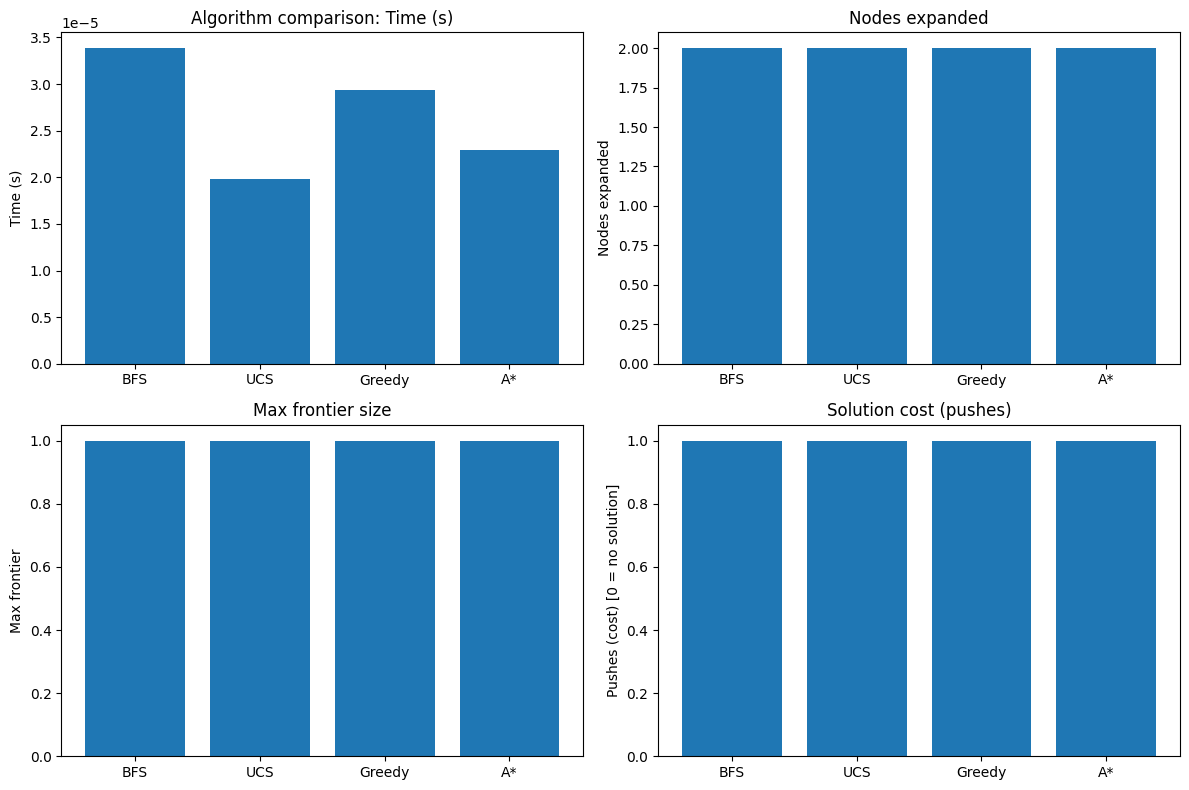


=== Summary ===
Alg      Found  Cost   Optimal? Time(s)    Nodes     
BFS      True   1      YES      0.000      2         
UCS      True   1      YES      0.000      2         
Greedy   True   1      YES      0.000      2         
A*       True   1      YES      0.000      2         


In [8]:
if __name__ == "__main__":
    # Define a simple solvable Sokoban level as a list of strings.
    # Legend:
    #   # : Wall
    #   space: Floor
    #   . : Goal position
    #   $ : Box position
    #   @ : Player position
    #   * : Box on a goal
    #   + : Player on a goal
    example_level = [
        "#####",
        "#@$.#", # Player at (1,1), Box at (1,2), Goal at (1,3)
        "#####"
    ]

    # Parse the example level into grid, player position, and box/goal sets
    grid, player, boxes, goals = parse_level(example_level)

    # Run all search algorithms and plot their performance for the parsed level
    results = run_all_and_plot(grid, player, boxes, goals)